# Text Classfication using Bidirection Recurrent Neural Network (BRNN)

### CSE4238 - Soft Computing Lab

Assignment : 3

ID: 170104116

Name: Rejone E Rasul Hridoy

Section : C1

In [ ]:
#library imports
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
import nltk
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
root_path = '/content/drive/MyDrive/CSE/4.2/CSE4238 - Soft Computing Lab/Assignment 3/'

# 1. Dataset

In [ ]:
#loading the data
df = pd.read_csv(root_path+'Dataset 3.csv',encoding='ISO-8859-1')
print(df.shape)
df.head()

(10314, 2)


,tweets,sentiment
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


## 1.1 - Dataset Cleaning

In [ ]:
# required libraries
import json
from tqdm.notebook import tqdm
import re,string
# download emot first
!pip install emot --upgrade
import emot 
emot_obj = emot.core.emot()

# required files for english contraction list
contraction_list = json.loads(open('/content/drive/MyDrive/CSE/4.2/CSE4238 - Soft Computing Lab/Assignment 3/english_contractions.json.txt', 'r').read())
character_entity= {'&lt;3':'heart', '&amp;':'and','&quot;':' quote '}
contraction_list = {**contraction_list, **character_entity}

     |████████████████████████████████| 61 kB 17 kB/s 


In [ ]:
def normalization_pipeline(sentences):
    print("##############################")
    print("Starting Normalization Process")
    sentences = _simplify_punctuation_and_whitespace(sentences) # !!!!! "      "
    sentences = _normalize_contractions(sentences) #also corrects spelling now
    print("Normalization Process Finished")
    print("##############################")
    return sentences
    
def _simplify_punctuation_and_whitespace(sentence_list):
    """
    words with more than 4 all-capital words will get <-EMPW 
    """
    norm_sents = []
    print("Replacing -URL- , Replacing @MENTION and #HASHTAG, Reducing character repetitions, ")
    print("Simplifying punctuation, Removing whitespaces")

    for sentence in tqdm(sentence_list):
        sent = _remove_urls_html_tags(sentence)
        sent = _mention_hash(sent)
        sent = _simplify_punctuation(sent)
        sent = _remove_non_ascii_characters(sent)
        sent = _reduce_repetitions(sent)
        sent = _normalize_whitespace(sent)
        norm_sents.append(sent)
    return norm_sents

def _remove_urls_html_tags(text):
    url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    text = re.sub(url_regex, "", text)

    """
    Removing html tag such as <p>
    """
    html_tag=re.compile(r'<.*?>')
    text=html_tag.sub(r'',text)
    return text

def _mention_hash(in_str):
    """
     @MENTIONs and #HASHTAGs will take forms of @men and #has 
    note: BEWARE OF USES OF # AND @ AND SPACES BETWEEN THEM
    """
    in_str = str(in_str)
    in_str = re.sub('@\w+', '', in_str,flags=re.IGNORECASE) # use @\w+ for word replacement or @ with space after @MEN for keeping mention
    in_str = re.sub('#', '', in_str,flags=re.IGNORECASE)
#     in_str = re.sub(r'([\w])\1+', r'\1\1', in_str) #reduce repeated characters to 2
    return in_str.strip()

def _simplify_punctuation(text):
    """
    puntuations like '!!!!!' will be transformed into ""
    This function simplifies doubled or more complex punctuation. The exception is '...'. #?! ??? !!!
    """
    corrected = str(text)
    corrected = re.sub(r'([!?,;])\1+', r'\1\1', corrected) #\1\1 makes it to 2 consecutive punctuation '<-EMPP'
    corrected = re.sub(r'\.{2,}', r'', corrected)
    return corrected

def _remove_non_ascii_characters(text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    return text

def _reduce_repetitions(text):
    """
    Auxiliary function to help with exxagerated (repeated characters in) words.
    Examples:
        woooooords -> woords 
        dooorwaaay -> doorwaay 
        SICK -> sick
    """
    correction = str(text)
    for index, words in enumerate(str(text).split()):
        if _is_EMP_word(words)==True :
            #insert EMPW after word
            correction = correction.replace(words, words + ' ')
        if (len(words) > 4) & (words.isupper()==True) & (words[0] not in string.punctuation):
            correction = correction.replace(words, words + ' ')
    #TODO work on complexity reduction.
    return re.sub(r'([\w])\1+', r'\1\1', correction) #\1\1 will only keep 2 consecutive characters


def _is_EMP_word(word):
    """
    True/ False: checks if the word has 3 consecutive characters"""
    count=1
    if len(word)>1:
        for i in range(1,len(word)):
            if word[i] in string.punctuation: #this function is only for words!
                return False
            if word[i-1]==word[i]:
                count+=1
                if(count>=3):
                     return True
            else :
                if(count>=3):
                    return True
                count=1
    else :
        return False
    return False


def _normalize_whitespace(text):
    """
    normalizes whitespaces, removing duplicates.
    """
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    corrected.replace("=", "")
    return corrected.strip(" ")

#Substitution of contractions:        
def _normalize_contractions(sentence_list):
    """
    it will correct each word in a sentence for slangs(ginger), emojis -> meaning, entity references and abbreviations(json file) : file can be manually modified above
    also makes everything lowercase (including EMPW,EMPU, EMPP, URL, etc)
    """
    norm_sents = []
    print("Normalizing contractions, abbreviations, slangs, emojis, character entities")
    for sentence in tqdm(sentence_list):
        norm_sents.append(_normalize_contractions_slang_emoji_entity(sentence))
    return norm_sents

def _normalize_contractions_slang_emoji_entity(text):
    """
    part1:normalizes english contractions.
    """
    contractions = contraction_list
    for word in text.split():
         if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
#             print('replacing contraction: '+ word + ' to '+contractions[word.lower()])

    sentence = text
    """
    part2: emoji and character entity reference conversion to meaning
    """
    emoticons = emot_obj.emoticons(sentence)

    for i in range(0,len(emoticons['value'])):
#         print('replacing  ' + emoticons['value'][i] + '  with ' +  emoticons['mean'][i])
        sentence = sentence.replace(emoticons['value'][i], emoticons['mean'][i])
    """
    part3: make everything lowercase
    """
    sentence.replace("&quot", "")
    sentence = sentence.lower()
    return sentence


In [ ]:
df_preprocessed = normalization_pipeline(df.tweets.values ) #about 10 minutes to run
df['tweets'] = pd.DataFrame(df_preprocessed)
df['sentiment'] = df['sentiment']
df

##############################
Starting Normalization Process
Replacing -URL- , Replacing @MENTION and #HASHTAG, Reducing character repetitions, 
Simplifying punctuation, Removing whitespaces


  0%|          | 0/10314 [00:00<?, ?it/s]

Normalizing contractions, abbreviations, slangs, emojis, character entities


  0%|          | 0/10314 [00:00<?, ?it/s]

Normalization Process Finished
##############################


,tweets,sentiment
0,"just had a real good moment. i miss him so much,",0
1,is reading manga,0
2,-,0
3,need to send 'em to my accountant tomorrow. od...,0
4,add me on myspace!! myspace.com/lookthunder,0
...,...,...
10309,no depression by g herbo is my mood from now o...,1
10310,what do you do when depression succumbs the br...,1
10311,ketamine nasal spray shows promise against dep...,1
10312,do not mistake a bad day with depression! ever...,1


In [ ]:
df['length'] = df['tweets'].apply(lambda x: len(str(x).split()))
df

,tweets,sentiment,length
0,"just had a real good moment. i miss him so much,",0,11
1,is reading manga,0,3
2,-,0,1
3,need to send 'em to my accountant tomorrow. od...,0,22
4,add me on myspace!! myspace.com/lookthunder,0,5
...,...,...,...
10309,no depression by g herbo is my mood from now o...,1,22
10310,what do you do when depression succumbs the br...,1,19
10311,ketamine nasal spray shows promise against dep...,1,9
10312,do not mistake a bad day with depression! ever...,1,11


# 2. Text Preprocessing

In [ ]:
# for tokenize
tok = spacy.load('en')
# for stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopword = stopwords.words('english')

# for lemmatize
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

def text_preprocessing (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)  # remove non-ascii characters
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    tokenized_words = [token.text for token in tok.tokenizer(nopunct)]
    filtered_words = [word for word in tokenized_words if word.lower() not in english_stopword]    # word.lower() is for lowering down the words
    text = [wn.lemmatize(word) for word in filtered_words]
    
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 3. Sentence Encoding

3.1 - Count number of occurences of each word

In [ ]:
counts = Counter()
for index, row in df.iterrows():
    counts.update(text_preprocessing(str(row['tweets'])))

3.2 - Deleting infrequent words

In [ ]:
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 14184
num_words after: 5546


3.3 - Word Frequency after processing

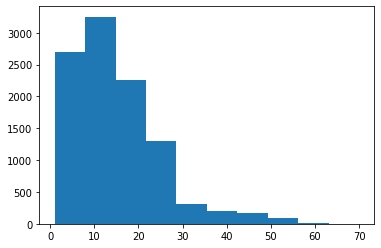

In [ ]:
lengths = [len(t.split(' ')) for t in df['tweets']]
plt.hist(lengths)
plt.show()

3.4 - Creating vocabulary

In [ ]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

3.5 - Encoding Sentence (Padding: 50)

In [ ]:
def encode_sentence(text, vocab2index, N=50):
    preprocessed = text_preprocessing(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in preprocessed])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [ ]:
df['encoded'] = df['tweets'].apply(lambda x: np.array(encode_sentence(str(x),vocab2index )))
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


,tweets,sentiment,length,encoded
0,"just had a real good moment. i miss him so much,",0,11,"[[2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,is reading manga,0,3,"[[8, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,-,0,1,"[[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,need to send 'em to my accountant tomorrow. od...,0,22,"[[9, 10, 5, 11, 1, 12, 5, 1, 5, 13, 14, 15, 5,..."
4,add me on myspace!! myspace.com/lookthunder,0,5,"[[19, 20, 21, 20, 22, 1, 0, 0, 0, 0, 0, 0, 0, ..."


3.6 - Checking how balanced the dataset is

In [ ]:
Counter(df['sentiment'])

Counter({0: 8000, 1: 2314})

# 4. Dataset Splitting

In [ ]:
X = list(df['encoded'])
y = list(df['sentiment'])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,random_state=116)

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [ ]:
train_ds = TweetDataset(X_train, y_train)
valid_ds = TweetDataset(X_valid, y_valid)

# 5. Glove Word Embedding

Here we will use glove 6B of 50 dimensions

In [ ]:
def load_glove_vectors(glove_file=root_path+'glove.6B.50d.txt'):
    """Load the glove word vectors"""
    word_vectors = {}
    with open(glove_file) as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

In [ ]:
def get_emb_matrix(pretrained, word_counts, emb_size = 50):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

In [ ]:
word_vecs = load_glove_vectors()
pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts)

In [ ]:
len(pretrained_weights)

5548

# 6. Bidirectional Recurrent Neural Network (BRNN) Model

In [ ]:
class BRNN(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, num_layers, hidden_dim, glove_weights, output_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False ## freeze embeddings
        self.rnn = nn.RNN(embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True,nonlinearity='tanh')
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        rnn_out, ht = self.rnn(x)
        return self.linear(ht[-1])


## 6.1 - Setting Hyperparameter

In [ ]:
batch_size = 100
vocab_size = len(words)
learning_rate = 0.01
embedding_dimension = 50
num_layers = 4
hidden_dimension = 50
output_layers = 2
epochs = 30

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

model = BRNN(vocab_size, embedding_dimension, num_layers, hidden_dimension, pretrained_weights, output_layers)

## 6.2 - Model Evaluation

In [ ]:
def train_model(model, epochs=10, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(1,epochs+1):
        model.train()
        sum_loss = 0.0
        total = 0
        train_count =0
        train_accuracy = 0.0
        
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()

            # Forward pass to get output
            y_pred = model(x, l)
            pred = torch.max(y_pred, 1)[1]
            
            # determining the accuracy score using sklearn library
            train_accuracy += accuracy_score(pred, y)

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Calculate Loss: cross entropy loss
            loss = F.cross_entropy(y_pred, y)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

            # calcualte total loss
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
            train_count += 1

        val_loss, val_rmse,val_acc, val_prec, val_recall, val_f1, val_cm = validation_metrics(model, val_dl)

        # save all perfomance matrix into list
        Train_ACC.append((train_accuracy/train_count)*100)
        Val_ACC.append(val_acc*100)
        PREC.append(val_prec*100)
        RECALL.append(val_recall*100)
        F1.append(val_f1*100)
        train_loss_data.append(sum_loss/total)
        val_loss_data.append(val_loss)
        if i % 5 == 0:
            CM.append(val_cm)
            print("Epoch %d: Train accuracy %.3f, Train loss %.3f, Val loss %.3f, Val accuracy %.3f, Precision %.3f, Recall %.3f and F1 score %.3f and val RMSE %.3f" 
                  % (i, (train_accuracy/train_count)*100, sum_loss/total, val_loss, val_acc*100, val_prec*100, val_recall*100, val_f1*100, val_rmse))

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total,test_count = 0,0
    sum_loss = 0.0
    sum_rmse = 0.0
    accuracy ,precision, recal, f1 = 0.0, 0.0, 0.0, 0.0
    cm = np.array([[0,0],[0,0]])
    
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()

        # Forward pass to get output
        y_hat = model(x, l)
        pred = torch.max(y_hat, 1)[1]

        # Calculate Loss: cross entropy loss
        loss = F.cross_entropy(y_hat, y)
        
        # determining accuracy, precision, recall, f1 score and confusion matrics
        accuracy += accuracy_score(pred, y)
        precision += precision_score(pred, y, average='macro')
        recal += recall_score(pred, y, average=None ,zero_division=1)[0]
        cm += confusion_matrix(pred,y)
        f1 += f1_score(pred, y, average='macro')
        test_count += 1

        # calcualte total loss
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, sum_rmse/total, accuracy/test_count, precision/test_count, recal/test_count, f1/test_count, cm

In [ ]:
# clear all the values of previous run
CM,Train_ACC,Val_ACC, PREC, RECALL, F1, train_loss_data, val_loss_data  = [],[],[],[],[],[],[],[]

# train the model and evaluate the model
train_model(model, epochs, learning_rate)

Epoch 5: Train accuracy 82.664, Train loss 0.431, Val loss 0.268, Val accuracy 95.460, Precision 92.147, Recall 95.980 and F1 score 93.072 and val RMSE 0.206
Epoch 10: Train accuracy 95.038, Train loss 0.168, Val loss 0.147, Val accuracy 95.249, Precision 96.425, Recall 99.495 and F1 score 93.361 and val RMSE 0.210
Epoch 15: Train accuracy 98.146, Train loss 0.080, Val loss 0.040, Val accuracy 99.305, Precision 98.551, Recall 99.227 and F1 score 98.947 and val RMSE 0.056
Epoch 20: Train accuracy 99.120, Train loss 0.049, Val loss 0.103, Val accuracy 98.163, Precision 95.953, Recall 97.672 and F1 score 97.237 and val RMSE 0.116
Epoch 25: Train accuracy 99.145, Train loss 0.051, Val loss 0.043, Val accuracy 99.353, Precision 98.580, Recall 99.228 and F1 score 99.026 and val RMSE 0.053
Epoch 30: Train accuracy 99.241, Train loss 0.044, Val loss 0.037, Val accuracy 99.401, Precision 98.778, Recall 99.281 and F1 score 99.143 and val RMSE 0.049


## 6.3 - Save the Model

In [ ]:
save_model = False
if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'Assignment 3_model.pkl')

## 6.4 - Load the Model

In [ ]:
load_model = False
if load_model is True:
    model.load_state_dict(torch.load(root_path + 'Assignment 3_model.pkl'))

# 7. Performance Visualization

## 7.1 - Confusion Matrix

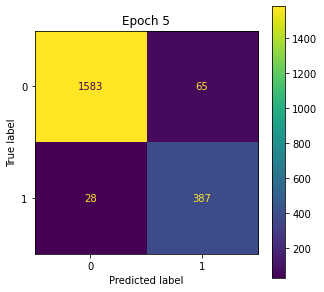

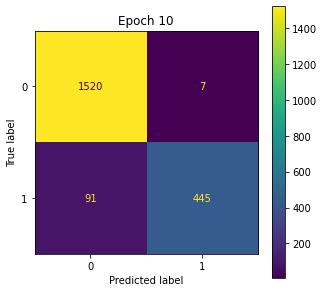

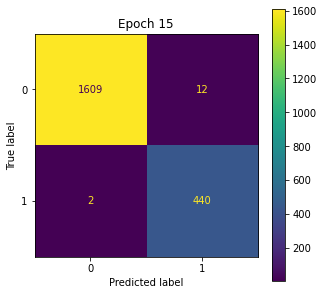

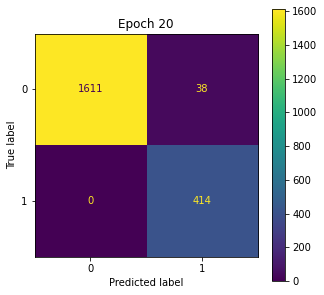

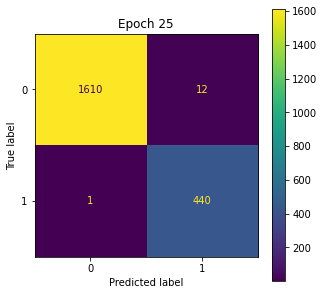

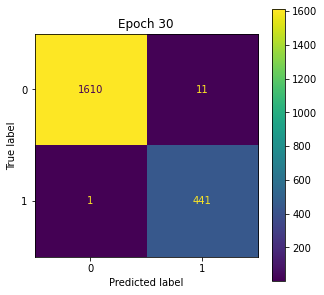

In [ ]:
for i in range(len(CM)):
    cm_display = ConfusionMatrixDisplay(CM[i], display_labels=['0','1'])
    fig, ax = plt.subplots(figsize=(5,5)) # adjust the size
    ax.title.set_text("Epoch "+str(i*5+5))
    cm_display.plot(ax=ax,values_format='')

## 7.2 - Performance Graph

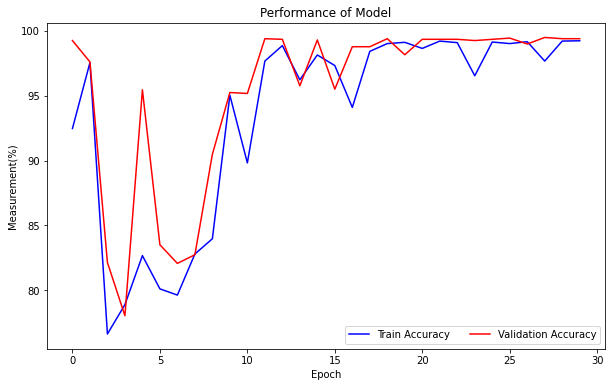

In [ ]:
plt.plot(Train_ACC, color='b',linestyle='-', label='Train Accuracy')
plt.plot(Val_ACC, color='r', linestyle='-', label='Validation Accuracy')
# plt.plot(PREC, color='g', linestyle='-', label='Precision')
# plt.plot(RECALL, color='k', linestyle='-', label='Recall')
# plt.plot(F1, color='c', linestyle='-', label='F1 Score')

plt.title('Performance of Model')
plt.xlabel('Epoch')
plt.ylabel('Measurement(%)')
plt.legend(loc='lower right',ncol=2)
# plt.ylim(5.55,11.55)
plt.rcParams["figure.figsize"] = (10,6)
plt.savefig('/content/drive/MyDrive/CSE/4.2/CSE4238 - Soft Computing Lab/Assignment 3/Performance of Model.jpg')
plt.show()

## 7.3 - Loss Curve

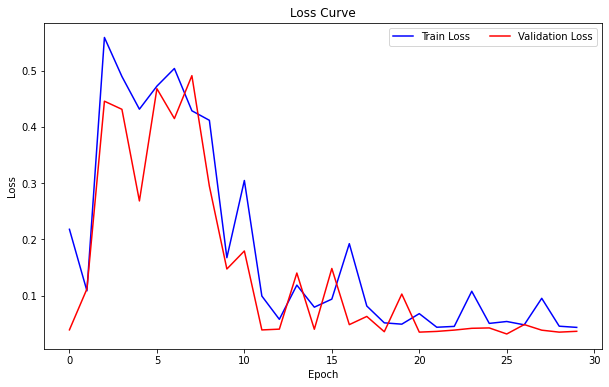

In [ ]:
plt.plot(train_loss_data, color='b',linestyle='-', label='Train Loss')
plt.plot(val_loss_data, color='r', linestyle='-', label='Validation Loss')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right',ncol=2)
# plt.ylim(5.55,11.55)
plt.rcParams["figure.figsize"] = (10,6)
plt.savefig('/content/drive/MyDrive/CSE/4.2/CSE4238 - Soft Computing Lab/Assignment 3/Loss Curve.jpg')
plt.show()

# 8. Prediction from user input

In [ ]:
text = "A human being can survive almost anything, as long as she sees the end in sight. But depression is so insidious, and it compounds daily, that it's impossible to ever see the end."
s = input('Enter text: ')
X = encode_sentence(str(s),vocab2index )
X = np.expand_dims(X[0], axis=0)
x = torch.from_numpy(X.astype('int32'))
l = len(str(s).split())
print(model(x,l))
print('Label:',(torch.max(model(x,l), 1)[1]).item())

Enter text: A human being can survive almost anything, as long as she sees the end in sight. But depression is so insidious, and it compounds daily, that it's impossible to ever see the end.
tensor([[-2.3364,  2.3610]], grad_fn=<AddmmBackward>)
Label: 1
